# **Financial Outcomes of Private Equity Portfolio Companies post-IPO**

<a id='abstract'></a>
## Abstract
Insert abstract here

Below is all the source code for the two analyses that I run in the paper along with some of the outputs. 


Click [here](#analysis_one) to jump to Analysis 1 <br>
Click [here](#analysis_two) to jump to Analysis 2

<a id='data_cleaning'></a>
## Data Cleaning and Initialization

In [1]:
!python3 -m pip freeze

anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens @ https://files.pythonhosted.org/packages/f3/e1/64679d9d0759db5b182222c81ff322c2fe2c31e156a59afd6e9208c960e5/asttokens-2.2.1-py2.py3-none-any.whl#sha256=6b0ac9e93fb0335014d382b8fa9b3afa7df546984258005da0b9e7095b3deb1c
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.1.0
blinker==1.4
CausalInference==0.1.3
certifi==2023.7.22
cffi==1.16.0
charset-normalizer==3.3.0
comm==0.1.4
command-not-found==0.3
contourpy==1.1.0
cryptography==3.4.8
cycler==0.11.0
dbus-python==1.2.18
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
distro==1.7.0
distro-info===1.1build1
exceptiongroup==1.1.3
executing==2.0.0
fab-classic @ https://files.pythonhosted.org/packages/6b/0f/efc537eebfd2a2c470250c0ac8bd8a05ffc13d95a7fb22021367890d7c46/fab_classic-1.19.2-py2.py3-none-any.whl#sha256=8edfd97ff58ca616cdd6e77bc42d3f71d27842197f13771c77cf0b553f3b4311
fastjsonschema==2.18.1
fonttools==4.42

In [3]:
# Run this cell to set up your notebook

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns 
import csv
# import scikit
import numpy as np
import pandas as pd
from psmpy.plotting import *
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from scikit-learn import LogisticRegression
from scipy import stats
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statistics import stdev
import pingouin as pg
import collections
import statsmodels.api as sm

%matplotlib inline
sns.set()
sns.set_context("talk")

from IPython.display import display, Latex, Markdown
pd.set_option('display.max_columns', 10)
plt.rcParams['figure.figsize'] = [10, 5]

SyntaxError: invalid syntax (1102286655.py, line 14)

In [3]:
# Importing Company Deal Info as well as company financials
deal_info = pd.read_csv(r'./company_list.csv')
company_fin = pd.read_csv(r'./company_financials_average_month_data.csv')

In [4]:
# Fill all empty company financials with column median
for col in company_fin.columns[2:]:
    company_fin[col] = company_fin[col].apply(pd.to_numeric, errors='coerce')
    company_fin[col] = company_fin[col].fillna(company_fin[col].median())


In [5]:
# company_fin.drop(columns=["Unnamed: 73","Unnamed: 74","Unnamed: 75","Unnamed: 76","Unnamed: 77"], inplace=True)
# Fill deal_info columns with median values
# If time, break into respective subindustry first and then 
col = ['Year Founded', 'Revenue',
       'Gross Profit', 'Net Income', 'EBITDA', 'EBIT', 'Total Debt',
       'Fiscal Year', 'Valuation/Ebitda', 'Valuation/EBIT',
       'Valuation/Net Income', 'Valuation/Revenue', 'Valuation / Cash Flow',
       'Deal Size/EBITDA', 'Deal Size/EBIT', 'Deal Size/Net Income',
       'Deal Size/Revenue', 'Deal Size/Cash Flow',
       'Employees', 'Total Invested Equity','Deal Size', 'Deal Year']

for c in col:
    deal_info[c] = deal_info[c].apply(pd.to_numeric, errors='coerce')
    deal_info[c] = deal_info[c].fillna(deal_info[c].median())

In [6]:
# cleaning all nan values and dropping first column of dataset
cleaned_fin = company_fin.fillna(0).drop(index = 0)
deal_info = deal_info.fillna(0)

deal_info["EBITDA Margin %"] = deal_info["EBITDA Margin %"].str.replace("%","")

deal_info["Company"] = deal_info["Company"].astype(str)
deal_info["EBITDA Margin %"] = deal_info["EBITDA Margin %"].astype(float)
deal_info["Employees"] = deal_info["Employees"].astype(int) 
deal_info["Total Invested Equity"] = deal_info["Total Invested Equity"].astype(float) 
deal_info = deal_info.fillna(0)


cleaned_fin.rename(columns={"Company Year":"Company", '    Revenue % Growth':'revenue_growth', 
                            '    EBITDA % Growth':'ebitda_growth', 'Net Income Growth':'net_income_growth', 
                         'ROE % Growth':'roe_growth', 'Liquidity % Growth':'liquidity_growth'}, inplace = True)
                         
cleaned_fin["Company"] = cleaned_fin["Company"].astype(str)

cleaned_fin.sort_values("Company", inplace=True)
cleaned_fin.columns

Index(['Company', 'Date of Financials', '    Total Revenue', 'revenue_growth',
       '    Gross Profit', '    Total Operating Profit/(Loss)', '    EBITDA',
       '    EBITDA (Normalized)', '    EBITDA (Analyst Normalized)',
       '    EBITDA Margin', 'ebitda_growth', '    EBIT',
       '    EBIT (Normalized)', '    EBIT % Growth', 'Updated EBIT Growth',
       '    EBIT (Analyst Normalized)',
       '    Net Income from Continuing Operations',
       '    Net Income Available to Common Stockholders',
       '    Net Income (Normalized)', 'net_income_growth',
       '    Net Income (Analyst Normalized)',
       '    Diluted EPS from Continuing Operations', '    Diluted EPS',
       '    Diluted EPS (Normalized)', '    EPS (Analyst Normalized)',
       '    Diluted Weighted Average Shares Outstanding',
       '    Total Current Assets', '    Net Property, Plant and Equipment',
       '    Total Non-Current Assets', '    Total Assets',
       '    Total Current Liabilities', '    Total

In [7]:
# Make sure we have data for all companies and then drop the data that isn't relevant for the analysis
# not enough data in consumer Products and services
# deal_info = deal_info[deal_info["Primary Industry Sector"] != "Consumer Products and Services (B2C)"]
deal_info = deal_info[deal_info["Company"].isin(cleaned_fin["Company"])]
cleaned_fin = cleaned_fin[cleaned_fin["Company"].isin(deal_info["Company"])]

deal_info[deal_info["Primary Industry Sector"] == "Consumer Products and Services (B2C)"]

# keep track of how many years company has been around for
years_around = []

for fiscal,founded in zip(deal_info["Deal Year"], deal_info["Year Founded"]):
    years = (fiscal - founded) if (fiscal > 0 and founded > 0) else 0
    years_around.append(years)

deal_info["Years Since Founding"] = years_around
deal_info["Years Since Founding"] = deal_info["Years Since Founding"].astype(int)

Next we need to clean the data such that the quarterly financials are being used effectively. I lose around 20,000 rows by factoring out and just keeping the december quarterly trends. The issue with this is that by doing so, I am potentially losing out on best performance months for companies that may historically suffer during Q4 of the year. For instance, consumer companies would tend to do better when compared to, say banks, in winter months as consumer spending increases in the holidays.

In [8]:
# we label the PE-treated firms with binary labels
def sum_and_avg_company_years(cleaned_fin, aggregate_mappings):
    _agg_fin = cleaned_fin
    display(cleaned_fin['Date of Financials'])
    # First change all company financial months into their respective years
    _agg_fin["Fin Year"] = _agg_fin["Date of Financials"].str.replace(r"-\w*", "", regex=True).astype(int) + 2000

    _rel_fin = cleaned_fin[cleaned_fin["Date of Financials"].str.startswith("-Dec")]
    _rel_fin["Fin Year"] = _rel_fin["Date of Financials"].str.replace("-Dec", "").astype(int) + 2000
    _rel_fin = _rel_fin[['Company', 'Fin Year', 'revenue_growth',
                         'ebitda_growth', 'net_income_growth', 
                         'roe_growth', 'liquidity_growth']]
    
        
    #Group by relative financial year and then average the data to account for seasonality and lack of quarters
    #For the time being, we will also keep growth estimates for only december growth patterns
    _agg_fin = _agg_fin.groupby(["Company", "Fin Year"]).agg(aggregate_mappings).reset_index()

    _agg_fin.merge(_rel_fin, on=['Company', 'Fin Year'])
    return _agg_fin

#Dictionary telling us which columns we should keep from the data that we have on hand
agg = {'    Total Revenue':np.mean,
       'revenue_growth':np.mean, 
       '    Gross Profit':np.mean,
       '    Total Operating Profit/(Loss)':np.mean, 
       '    EBITDA':np.mean,
       '    EBITDA (Normalized)':np.mean,
       '    EBITDA Margin':np.mean, 
       'ebitda_growth':np.mean,
       '    Net Income (Normalized)':np.mean,
       'net_income_growth':np.mean,
       '    Net Income (Analyst Normalized)':np.mean,
       '    Diluted EPS':np.mean,
       '    Diluted Weighted Average Shares Outstanding':np.mean,
       '    Total Current Assets':np.mean, 
       '    Net Property, Plant and Equipment':np.mean,
       '    Total Non-Current Assets':np.mean, 
       '    Total Assets':np.mean,
       '    Total Current Liabilities':np.mean, 
       '    Total Non-Current Liabilities':np.mean,
       '    Total Liabilities':np.mean, 
       '    Total Equity':np.mean,
       'ROE':np.mean,  
       'roe_growth':np.mean,
       '    Equity Attributable to Parent Stockholders':np.mean,
       '    Total Debt':np.mean,
       '    Total Shares Outstanding (TSO)':np.mean,
       '    Working Capital':np.mean,
       '    Change in Cash':np.mean,
       '    Capital Expenditure (Calc)':np.mean,
       '    Issuance of/(Payments for) Common Stock, Net':np.mean,
       '    Cash Dividends Paid':np.mean,
       '    Cash and Cash Equivalents, Beginning of Period':np.mean,
       '    Cash and Cash Equivalents, End of Period':np.mean,
       'liquidity_growth':np.mean,
       '    Net Income from Continuing Operations Sequential % Growth':np.mean,
       '    Net Income Available to Common Stockholders Sequential % Growth':np.mean,
       '    Current Ratio':np.mean,
       '    Quick Ratio':np.mean,
       '    Debt to Equity':np.mean,
       '    Total Debt to Equity':np.mean,
       '    Total Asset Turnover':np.mean,
       '    Normalized Return on Equity':np.mean,
       '    Normalized Return on Assets':np.mean,
       '    Normalized Return on Invested Capital':np.mean,
       '    Stock Price':np.mean,
       '    Market Cap':np.mean,
       '    EV':np.mean,
       '    EV to Revenue':np.mean,
       '    EV to EBIT':np.mean,
       '    EV to EBIT (Normalized)':np.mean,
       '    EV to EBIT (Analyst Normalized)':np.mean,
       '    EV to EBITDA':np.mean,
       '    EV to EBITDA (Normalized)':np.mean,
       '    EV to EBITDA (Analyst Normalized)':np.mean,
       '    Price to Earnings':np.mean,
       '    Price to Earnings (Normalized)':np.mean,
       '    Price to Earnings (Analyst Normalized)':np.mean,
       '    Forward Price to Earnings':np.mean,
       '    Price to Book (PB)':np.mean,
       '    Price to Cash Flow (PCF)':np.mean,
       '    Price to Tangible Book Value':np.mean}

_rel_fin = sum_and_avg_company_years(cleaned_fin, agg)

1        10-Dec
22       13-Mar
23       14-Mar
24       15-Mar
25       16-Mar
          ...  
27463    12-Dec
27461    10-Dec
27477    14-Sep
27468    14-Jun
27476    13-Sep
Name: Date of Financials, Length: 30555, dtype: object

In [9]:
# def split_by_sector(df, column):
    
#     sector_specific_df = []
#     for sector in df[column].unique():
#         new_df = df[df[column] == sector]
#         sector_specific_df.append(new_df)
#     return sector_specific_df


# deal_info.columns

Index(['PE', 'Company', 'Primary Industry Sector', 'Year Founded', 'Revenue',
       'Gross Profit', 'Net Income', 'EBITDA', 'EBIT', 'Total Debt',
       'Fiscal Year', 'Valuation/Ebitda', 'Valuation/EBIT',
       'Valuation/Net Income', 'Valuation/Revenue', 'Valuation / Cash Flow',
       'Deal Size/EBITDA', 'Deal Size/EBIT', 'Deal Size/Net Income',
       'Deal Size/Revenue', 'Deal Size/Cash Flow', 'EBITDA Margin %',
       'Employees', 'Total Invested Equity', 'CEO Pbid', 'CEO', 'Deal Date',
       'Deal Size', 'Deal Year', 'Years Since Founding'],
      dtype='object')

In [10]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    if fence_low == np.nan or fence_high == np.nan or fence_high == fence_low:
        return df_in
    else:
        df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    
    return df_out

def rmv_all_outliers(df_list):
    cleaned_list = []
    for df in df_list:
        for col in df.columns:
            if is_numeric_dtype(df[col]):
                df = remove_outlier(df, col)
        cleaned_list.append(df)
    return cleaned_list

<a id='analysis_one'></a>
## **Analysis 1 - Propensity Score Estimation**

Through my analysis I investigate differences in revenue, EBITDA, net income, liquidity, and ROE growth rates of PE-treated and non-treated companies at one-, three-, and five-years after IPO. I find no statistical significance in revenue growth, net income growth, and ROE growth. However, I do find statistical significance in both liquidity and EBITDA growth. These results go in hand with the business model of private equity firms. Firms raise as much debt as possible when acquiring businesses, and thus the cash at hand (liquidity) that these companies will have to pay off debt is directly impacted by the amount of debt they take on. For each growth measure of growth tested, I compile my results in the form of an attached table and violin plot to demonstrate the distribution of data between treated and control groups.

In [12]:
category = ["Primary Industry Sector"]

data_with_categ = pd.concat([deal_info.drop(columns=category),
                            pd.get_dummies(deal_info[category], columns=category, drop_first=False)], axis=1)
data_with_categ.shape

(953, 36)

In [13]:
data_with_categ_merged = data_with_categ.merge(_rel_fin, left_on=['Company', 'Fiscal Year'], 
                                        right_on=['Company', 'Fin Year'], how="left")
data_with_categ_merged.shape

(953, 98)

In [14]:
T = 'PE'

X_axis = ['Revenue', 'Gross Profit', 'Net Income', 'EBITDA', 'EBIT', 'Total Debt',
       'Valuation/Ebitda', 'Valuation/EBIT', 'Valuation/Net Income',
       'Valuation/Revenue', 'Valuation / Cash Flow', 'EBITDA Margin %',
       'Employees', 'Years Since Founding',
       'Primary Industry Sector_Business Products and Services (B2B)',
       'Primary Industry Sector_Consumer Products and Services (B2C)',
       'Primary Industry Sector_Energy',
       'Primary Industry Sector_Financial Services',
       'Primary Industry Sector_Healthcare',
       'Primary Industry Sector_Information Technology']
#'Primary Industry Sector_Materials and Resources'
ps_model = LogisticRegression(C=1e6, fit_intercept=True).fit(data_with_categ_merged[X_axis], data_with_categ_merged[T])
data_ps = data_with_categ_merged.assign(propensity_score=ps_model.predict_proba(data_with_categ_merged[X_axis])[:, 1])
print(data_ps["propensity_score"])

0      4.369865e-01
1      4.330911e-01
2      1.233313e-31
3      4.457844e-01
4      4.346300e-01
           ...     
948    4.523957e-01
949    4.125115e-01
950    9.303428e-02
951    3.994723e-01
952    1.756883e-01
Name: propensity_score, Length: 953, dtype: float64


In [15]:
df = data_ps[X_axis]
df[X_axis[:11]].cov()

,Revenue,Gross Profit,Net Income,EBITDA,EBIT,...,Valuation/Ebitda,Valuation/EBIT,Valuation/Net Income,Valuation/Revenue,Valuation / Cash Flow
Revenue,1.334361e+08,9.384453e+06,3.756837e+06,2.838350e+06,2.233203e+06,...,-1.707869e+05,2.772261e+05,-7.265106e+05,6.034651e+08,1.164774e+06
Gross Profit,9.384453e+06,1.358652e+07,2.463362e+05,6.646144e+05,4.467949e+05,...,-4.386152e+04,5.886197e+04,-1.625285e+05,1.234982e+08,-1.219959e+05
Net Income,3.756837e+06,2.463362e+05,4.704443e+07,1.805536e+05,1.632355e+05,...,-2.949549e+04,4.261536e+04,-1.191510e+05,1.007039e+08,-1.192249e+05
EBITDA,2.838350e+06,6.646144e+05,1.805536e+05,3.581498e+05,2.811920e+05,...,-1.146574e+04,1.953975e+04,-3.099142e+04,4.085379e+07,-6.281453e+04
EBIT,2.233203e+06,4.467949e+05,1.632355e+05,2.811920e+05,3.188727e+05,...,-7.265976e+03,1.475043e+04,-1.092121e+04,3.388911e+07,-4.293408e+04
Total Debt,7.388893e+06,8.715071e+05,1.219026e+07,5.153300e+05,3.735128e+05,...,-9.458541e+04,1.457274e+05,-3.340506e+05,3.016509e+08,-2.878470e+05
Valuation/Ebitda,-1.707869e+05,-4.386152e+04,-2.949549e+04,-1.146574e+04,-7.265976e+03,...,2.522127e+07,3.611236e+06,-4.362541e+04,4.655747e+07,-6.555782e+04
Valuation/EBIT,2.772261e+05,5.886197e+04,4.261536e+04,1.953975e+04,1.475043e+04,...,3.611236e+06,1.773039e+07,1.390835e+07,-6.180117e+07,-1.881250e+05
Valuation/Net Income,-7.265106e+05,-1.625285e+05,-1.191510e+05,-3.099142e+04,-1.092121e+04,...,-4.362541e+04,1.390835e+07,3.335016e+08,1.932467e+08,-5.021954e+05
Valuation/Revenue,6.034651e+08,1.234982e+08,1.007039e+08,4.085379e+07,3.388911e+07,...,4.655747e+07,-6.180117e+07,1.932467e+08,1.061441e+14,1.755910e+08


As can be seen below, the weights of the data are not representative of the total sample size, but are importantly similar to each other. This would indicate that all least some of the confounders used to relatively compare portfolio and non-treated companies were well-captured in the model.

After this, I graph the distribution of propensity scores for both groups of company data. What I get as a result is significant overlap between propensity scores of treated and non-treated companies. The distributions are also *relatively* centered close to 0.5.

In [16]:
#Weights of the data
weight_t = 1/data_ps.query("PE==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("PE==0")["propensity_score"])
print("Original sample size:", deal_info.shape[0])
print("Treated pop. sample size:", sum(weight_t))
print("Unreated pop. sample size:", sum(weight_nt))

Original sample size: 953
Treated pop. sample size: 1461.876991808804
Unreated pop. sample size: 1497.595266086251


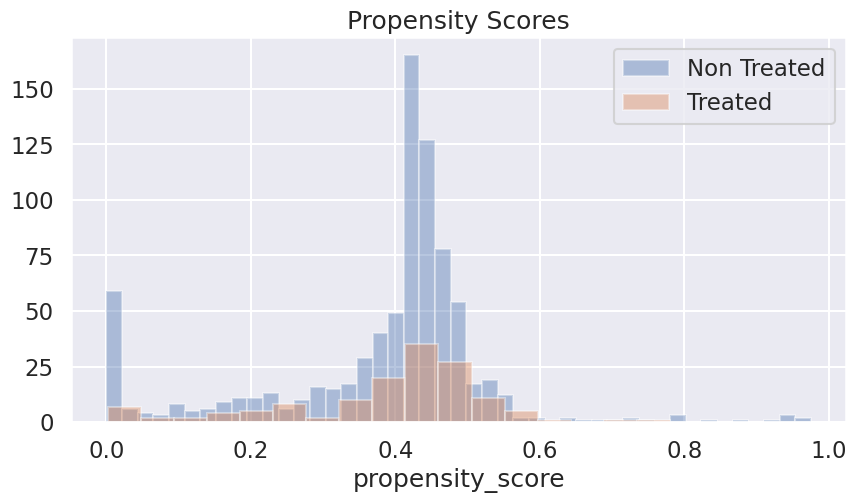

In [17]:
less_than_1 = data_ps.query("PE==1")["propensity_score"] 
# less_than_1 = less_than_1[less_than_1 < 0.4]

less_than_0 = data_ps.query("PE==0")["propensity_score"] 
# less_than_0 = less_than_0[less_than_0 < 0.4]
sns.distplot(less_than_0, kde=False, label="Non Treated")
sns.distplot(less_than_1, kde=False, label="Treated")
plt.legend()
plt.title("Propensity Scores");

In [18]:
# Once we have matched companies we can work on analyzing company data
# Here we are adding labels to each of the columns
pe_firms = deal_info.query("PE==1")
names = pe_firms['Company'].unique()
treatment = []
for val in _rel_fin['Company']:
    t = 1 if val in names else 0
    treatment.append(t)
_rel_fin["PE"] = treatment
_rel_fin

,Company,Fin Year,Total Revenue,revenue_growth,Gross Profit,...,Forward Price to Earnings,Price to Book (PB),Price to Cash Flow (PCF),Price to Tangible Book Value,PE
0,21st Century Fox,2009,3.011300e+07,-0.099438,10716000.00,...,16.964540,2.997291,11.743515,5.397673,0
1,21st Century Fox,2010,3.280075e+07,0.068735,11778000.00,...,16.896756,2.046234,12.529467,2.760365,0
2,21st Century Fox,2011,2.673775e+07,-0.183975,9555750.00,...,14.730429,6.203206,375.381290,9.716449,0
3,21st Century Fox,2012,2.381975e+07,-0.099453,8805750.00,...,17.191405,22.093187,74.548488,55.735287,0
4,21st Century Fox,2013,2.666500e+07,0.131532,9505000.00,...,27.421214,3.852253,10.957098,3.713417,0
...,...,...,...,...,...,...,...,...,...,...,...
9406,pSemi,2010,9.006850e+04,0.049340,41012.50,...,71.482270,0.937844,19.612806,0.937844,0
9407,pSemi,2011,9.577900e+04,0.113700,38827.75,...,14.940033,19.895416,14.458827,33.410760,0
9408,pSemi,2012,1.615015e+05,0.673096,56768.00,...,47.597098,2.878573,113.360359,3.037918,0
9409,pSemi,2013,2.151772e+05,0.387057,88913.75,...,56.659680,5.866014,34.795670,9.437369,0


In [19]:
# defines function to return relevant financial of the company per year
def fin_by_year(df, company_name, year_after_deal):
    year = df[df['Company'] == company_name]['Deal Year'].values[0] + year_after_deal
    return _rel_fin[(_rel_fin['Company'] == company_name) & (_rel_fin['Fin Year'] == year)]

def x_years_out(df, years):
    names = df['Company'].unique()
    df_orig = df
    x_year_data = []
    for company in names:
        df = fin_by_year(df_orig, company, years)
        x_year_data.append(df)
    df_out = pd.concat(x_year_data)
    return df_out

In [20]:
# make dictionary of prop scores mapping name to score
_rel_fin['propensity_score'] = _rel_fin['Company']

new_map = {}
for index, deal in data_ps.iterrows():
        comp = deal["Company"]
        if comp not in new_map:
            new_map[comp] = deal["propensity_score"]
            

In [21]:
_rel_fin["propensity_score"] = _rel_fin["propensity_score"].replace(new_map)
_rel_fin = _rel_fin[_rel_fin["Company"].isin(new_map.keys())]

_rel_fin["propensity_score"] = _rel_fin["propensity_score"].astype(float)
# _rel_fin["propensity_score"].sort_values()
_rel_fin

,Company,Fin Year,Total Revenue,revenue_growth,Gross Profit,...,Price to Book (PB),Price to Cash Flow (PCF),Price to Tangible Book Value,PE,propensity_score
0,21st Century Fox,2009,3.011300e+07,-0.099438,10716000.00,...,2.997291,11.743515,5.397673,0,0.000796
1,21st Century Fox,2010,3.280075e+07,0.068735,11778000.00,...,2.046234,12.529467,2.760365,0,0.000796
2,21st Century Fox,2011,2.673775e+07,-0.183975,9555750.00,...,6.203206,375.381290,9.716449,0,0.000796
3,21st Century Fox,2012,2.381975e+07,-0.099453,8805750.00,...,22.093187,74.548488,55.735287,0,0.000796
4,21st Century Fox,2013,2.666500e+07,0.131532,9505000.00,...,3.852253,10.957098,3.713417,0,0.000796
...,...,...,...,...,...,...,...,...,...,...,...
9406,pSemi,2010,9.006850e+04,0.049340,41012.50,...,0.937844,19.612806,0.937844,0,0.454995
9407,pSemi,2011,9.577900e+04,0.113700,38827.75,...,19.895416,14.458827,33.410760,0,0.454995
9408,pSemi,2012,1.615015e+05,0.673096,56768.00,...,2.878573,113.360359,3.037918,0,0.454995
9409,pSemi,2013,2.151772e+05,0.387057,88913.75,...,5.866014,34.795670,9.437369,0,0.454995


In [22]:
data_results = []
for years in [1,3,5]:
    x_year = x_years_out(data_ps, years)
    data_results.append(x_year)

# Making a function that does the same thing below to not mess up anything
def data_time_horizon(dataset, list_of_years):
    data_results = []
    for years in list_of_years:
        x_year = x_years_out(dataset, years)
        data_results.append(x_year)
    return data_results
    
data_results[0]

,Company,Fin Year,Total Revenue,revenue_growth,Gross Profit,...,Price to Book (PB),Price to Cash Flow (PCF),Price to Tangible Book Value,PE,propensity_score
1665,CEA Industries,2012,1.000000e+00,0.000000,1.728650e+05,...,2.462445,11.743515,2.866275,0,4.369865e-01
1622,Byrna Technologies,2014,4.903650e+01,0.176880,2.027250e+01,...,2.568056,13.147886,2.864354,0,4.330911e-01
5124,MassRoots,2016,6.872765e+02,31.182707,1.297790e+05,...,4.351175,19.842213,6.886669,0,1.233313e-31
5491,NV5,2014,9.007700e+04,0.374330,4.074850e+04,...,5.503601,50.681324,6.117205,0,4.457844e-01
2169,Clearsign Technologies,2013,3.575000e+01,0.024670,8.643775e+04,...,6.686103,11.434613,12.727938,0,4.346300e-01
...,...,...,...,...,...,...,...,...,...,...,...
6773,Rayonier Advanced Materials,2015,9.421538e+05,-0.037560,2.049662e+05,...,1.894481,8.876890,2.183499,0,4.523957e-01
6893,Resolute Forest Products,2011,4.829250e+06,0.062700,1.155500e+06,...,2.886115,11.576446,2.303372,0,4.125115e-01
8764,Veritiv,2015,8.729700e+06,0.421311,1.513350e+06,...,2.208690,15.558270,2.248823,0,9.303428e-02
8784,Versum Materials,2017,1.106825e+06,0.136661,4.812750e+05,...,3.145762,14.328754,2.866275,0,3.994723e-01


In [23]:
for df in data_results:
    var_to_analyze = 'liquidity_growth'
    df = df = remove_outlier(df, var_to_analyze)
    Y = df[var_to_analyze].values #scale the variables
    X = df[["PE","propensity_score"]].values

    model = sm.OLS(Y,X)
    results = model.fit()
    display(results.params)
    print(results.t_test([1, 0]))
    print("Number of Observations: ", Y.size)

array([-0.00773371, -0.06616268])

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0077      0.013     -0.590      0.555      -0.033       0.018
Number of Observations:  795


array([ 0.01150159, -0.01289513])

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0115      0.019      0.608      0.543      -0.026       0.049
Number of Observations:  727


array([-0.02696625, -0.0549646 ])

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0270      0.014     -1.879      0.061      -0.055       0.001
Number of Observations:  647


In [68]:
vars_to_analyze = ['revenue_growth','ebitda_growth','net_income_growth','liquidity_growth','roe_growth']
for var_to_analyze in vars_to_analyze:
    models = []
    t_tests = []
    year = 1;
    for df in data_results:
        df = remove_outlier(df, var_to_analyze)
        Y = df[var_to_analyze]
        X = df[["PE","propensity_score"]]
        X['Y'] = Y
        mod = smf.ols('Y ~ propensity_score + PE', data=X)
        res = mod.fit()
        t_test = res.t_test('PE = 0')
        print(f"\nYear {year} results for {var_to_analyze}")
        display(t_test)
        t_tests.append(t_test)
        models.append(res)
    # stargazer = Stargazer(models)             #USED TO OUTPUT THE MODEL IN LATEX FORMAT
    # display(Latex(stargazer.render_latex()))  #USED TO OUTPUT THE MODEL IN LATEX FORMAT


Year 1 results for revenue_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0199      0.023     -0.855      0.393      -0.066       0.026


Year 1 results for revenue_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0267      0.022     -1.217      0.224      -0.070       0.016


Year 1 results for revenue_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0140      0.024      0.584      0.559      -0.033       0.061


Year 1 results for ebitda_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1735      0.023      7.611      0.000       0.129       0.218


Year 1 results for ebitda_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0337      0.020      1.648      0.100      -0.006       0.074


Year 1 results for ebitda_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0267      0.024      1.106      0.269      -0.021       0.074


Year 1 results for net_income_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0323      0.014      2.356      0.019       0.005       0.059


Year 1 results for net_income_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0095      0.017     -0.571      0.568      -0.042       0.023


Year 1 results for net_income_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0029      0.014      0.205      0.838      -0.025       0.031


Year 1 results for liquidity_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0008      0.013     -0.065      0.949      -0.027       0.025


Year 1 results for liquidity_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0111      0.019      0.581      0.561      -0.026       0.049


Year 1 results for liquidity_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0217      0.014     -1.505      0.133      -0.050       0.007


Year 1 results for roe_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0038      0.018      0.216      0.829      -0.031       0.038


Year 1 results for roe_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0129      0.020      0.647      0.518      -0.026       0.052


Year 1 results for roe_growth


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0105      0.019     -0.561      0.575      -0.047       0.026

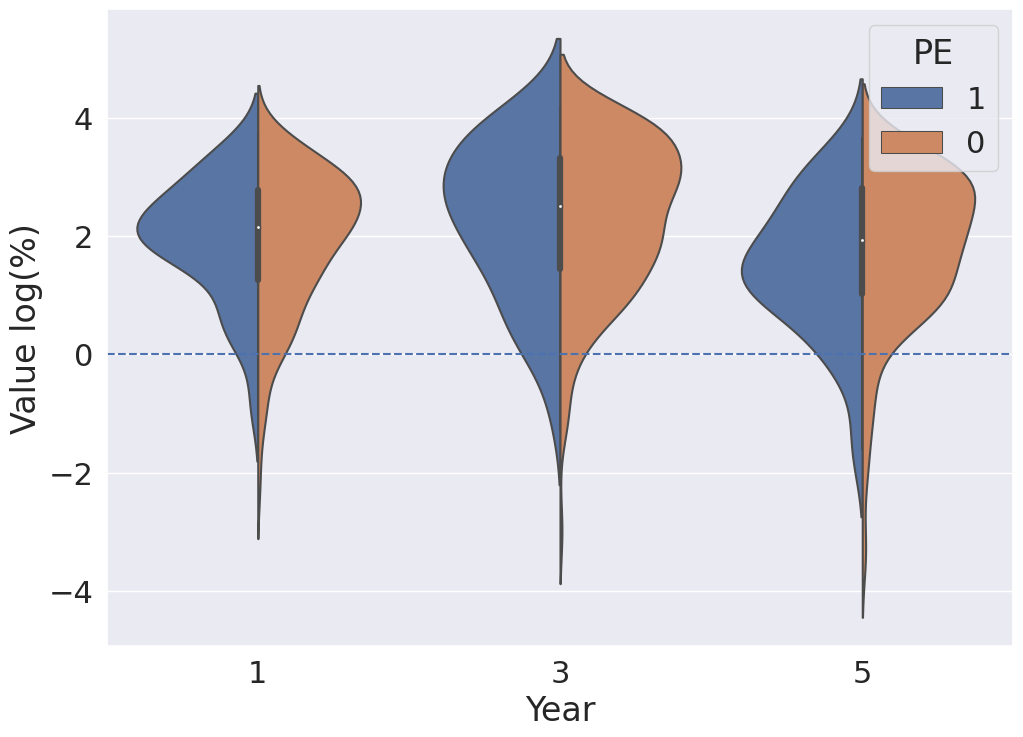

In [66]:
# Comment out and uncomment the variables that you'd like to display to compare the against the two 
vars_to_analyze = ['liquidity_growth'] #'roe_growth','revenue_growth','ebitda_growth','net_income_growth','liquidity_growth']

# Outputs a violin plot for both treated and non-treated companies per variable
# passed into to model
def show_var_distributions(vars_to_analyze:list[str], data_results:pd.DataFrame) -> None:
    pe = []
    no_pe = []
    for var_to_analyze in vars_to_analyze:
        count = 0
        for i in [1,3,5]:
            df = data_results[count]
            df = remove_outlier(df, var_to_analyze)
            Y = df[var_to_analyze] * 100
            X = df[["PE","propensity_score"]]
            X['Y'] = Y
            x_1 = X.query("PE==1")['Y']
            x_1 = x_1[x_1 > 0]
            x_1 = np.log(x_1.values)
            
            x_pe = x_npe = np.full(len(x_1), 1, dtype=str)
            arr = np.full(len(x_1), i, dtype=str)
            data = {"Year":arr,"Value":x_1,"PE":x_pe}
            
            x_0 = X.query("PE==0")['Y']
            x_0 = x_0[x_0 > 0]
            x_0 = np.log(x_0.values)
            x_npe = np.full(len(x_0), 0, dtype=str)
            arr_o = np.full(len(x_0), i, dtype=str)
            dato = {"Year":arr_o,"Value":x_0,"PE":x_npe}
            
            do = pd.DataFrame(dato)
            
            df = pd.DataFrame(data)
            
            pe.append(pd.concat([df,do], axis=0))
            
            count +=1
    df = pd.concat(pe, axis=0)
    sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=2)
    ax = sns.violinplot(df, x = "Year", y="Value", hue='PE', split=True)
    ax.set(ylabel='Value log(%)')
    ax.axhline(0, ls='--')
    plt.show()

show_var_distributions(vars_to_analyze, data_results)

<a id='analysis_two'></a>
## **Analysis 2 - Financial Performance Event Study**

### **Data Preparation and Calculating the Event Window**
Cleaning the Data was pretty straightforward. Because I already had methods to extract rows of company financials based on the amount of years from IPO, all I really had to do in this step was to create a new data table for each company ranging from three years before IPO to five years after. The amount of datapoints ranges from company to company.

In [67]:
## CALCULATING THE EVENT WINDOW

# break down information on companies on a yearly basis trusting for the moment that this works
COMPANY_FINANCIALS_BY_IPO_DELTA = data_time_horizon(data_ps, [x for x in range(-3, 6)])

for i in range(len(COMPANY_FINANCIALS_BY_IPO_DELTA)):
    frame = COMPANY_FINANCIALS_BY_IPO_DELTA[i]
    frame = frame.query("PE==1")
    COMPANY_FINANCIALS_BY_IPO_DELTA[i] = frame

#Extracts company data from the COMPANY_FINANCIALS_BY_IPO_DELTA table
def get_company_deltas(company_name:str):
    first_entry = COMPANY_FINANCIALS_BY_IPO_DELTA[0]
    company_deltas = first_entry[first_entry["Company"] == company_name]
    for set in COMPANY_FINANCIALS_BY_IPO_DELTA[1:]:
        year_data = set[set["Company"] == company_name]
        company_deltas = pd.concat([company_deltas, year_data], axis=0)
    return company_deltas


To verify that the model works, I first test the analysis one one company in particular.

The company, GoDaddy, was chosen at random.

In [47]:
# Example to show that it works for 1 company -- to be extracted later
go_daddy_data = get_company_deltas("GoDaddy")

### **Estimating Normal Performance**

In [63]:
#Returns a boolean to see if the specified financial year is in the event window
def in_event_window(company, row):
    return data_ps[data_ps['Company'] == company]["Deal Year"] < row['Fin Year']

#Returns a boolean to see if the specified financial year is in the estimation window
def in_estimation_window(company, row):
    return ~in_event_window(company, row)

#Later to be abstracted to work for all companies
#Returns a DataFrame of company financials that are in the estimation window
def estimation_window(company_data:pd.DataFrame)->pd.DataFrame:
    return company_data.apply(lambda row:in_event_window('GoDaddy', row), axis=1)


In [64]:
# Years less than or equal to the IPO. These will be what use to calculate normal performance
estimation_window = go_daddy_data.apply(lambda row: in_estimation_window('GoDaddy', row), axis=1).iloc[:,0]
estimates = go_daddy_data[estimation_window]

# Financials for all years after the IPO that we want to analyze the normal performance with
event_window = estimation_window = go_daddy_data.apply(lambda row: in_event_window('GoDaddy', row), axis=1).iloc[:,0]
events = go_daddy_data[event_window]

def estimation_and_event_windows(company_data, company):
    estimation_window = company_data.apply(lambda row: in_estimation_window(company, row), axis=1).iloc[:,0]
    estimates = company_data[estimation_window]

    event_window = estimation_window = company_data.apply(lambda row: in_event_window(company, row), axis=1).iloc[:,0]
    events = company_data[event_window]

    return estimates, events




Once we have the proper tuples of data, we can now run a regression on the estimation window to see what normal performance was and then save the alphas. For now, using dummy cols which I think could be roughly correlated.

In [30]:
REGRESSOR_COLS = ['    Gross Profit', '    Diluted EPS', '    Cash Dividends Paid', '    Debt to Equity', '    Stock Price', '    Price to Tangible Book Value']
regressors = estimates[REGRESSOR_COLS]

In [31]:
regressors.iloc[1]

    Gross Profit                    656900.000000
    Diluted EPS                          1.250000
    Cash Dividends Paid             -19301.000000
    Debt to Equity                       0.350007
    Stock Price                          6.360000
    Price to Tangible Book Value         0.391306
Name: 3696, dtype: float64

<b/>Now I fit the model to EBITDA Growth to see how it is impacted</b>

In [32]:
# Creating sm OLS models for each of the variables that I intend to analyze
# The OLS models are contained in a dictionary mapped to the analyzed variable's name
vars_to_analyze = ['roe_growth','revenue_growth','ebitda_growth','net_income_growth','liquidity_growth']

# Returns a dictionary of models for the company estimates passed in
def create_company_models(estimates, regressors, vars_to_analyze):
    models = {}
    
    for var in vars_to_analyze:
        growth = estimates[var]
        Y = growth
        # display(regressors)
        X = sm.add_constant(regressors, has_constant='add')
        # display(X.columns)
        model = sm.OLS(Y, X)
        results = model.fit()
        models[var] = results
    return models

go_daddy_models = create_company_models(estimates, regressors, vars_to_analyze)
go_daddy_models

{'roe_growth': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa584f7dfc0>,
 'revenue_growth': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa584f7c1f0>,
 'ebitda_growth': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa584f7e440>,
 'net_income_growth': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa584f7f850>,
 'liquidity_growth': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa584f7e530>}

### **Testing for Abnormal Returns**

Now we are able to test for significance in the testing window. To do this, we must add up the difference between what the model predicted and what the actual estimate was for the given year.

In [33]:
def cumulative_abnormal_return(models, events, vars_to_analyze, regressor_cols):
    abn_returns = {}
    reg = regressor_cols[:]
    reg.extend(vars_to_analyze)
    event = events[reg]
    reg = ['const'] + regressor_cols[:] 
    for var in vars_to_analyze:
        abn_list = []
        if var in models:
            sample = sm.add_constant(event, has_constant='add')
            abn = models.get(var).predict(sample[reg])
            abn = event[var] - abn
            abn_returns[var] = abn.tolist()
    return abn_returns

all_abnormal_returns = cumulative_abnormal_return(go_daddy_models, events, vars_to_analyze, REGRESSOR_COLS)

{'roe_growth': [0.6017351899945822,
  0.0600026226357614,
  -0.6757278365937665,
  1.893343782396052,
  11.698820407343856],
 'revenue_growth': [0.13365210708455097,
  -0.20793978682753325,
  -0.33742239240255534,
  0.19105799648623872,
  1.0510651787173055],
 'ebitda_growth': [-1.313556633035696,
  -7.85710836792797,
  -6.774906501951622,
  -7.420150454440662,
  -45.08892874110571],
 'net_income_growth': [0.019712562387831277,
  -2.0132527420814945,
  -1.843529222609006,
  -0.512017878915159,
  -10.405234213527004],
 'liquidity_growth': [-43.06149336625114,
  -375.8783505627703,
  -273.87776813181415,
  -302.6153918868123,
  -2624.9812448981697]}

In [34]:
def simple_sig_test_estimates(predicted_var, abnormal_returns):
    simple_sig_test = (sum(abnormal_returns)/len(abnormal_returns))/(stdev(abnormal_returns)/(len(abnormal_returns)**.5))
    return simple_sig_test

def compute_company_estimates(all_abnormal_returns):
    estimates = {}
    for k, v in all_abnormal_returns.items():
        if (len(v) > 2) and not all([x==0 for x in v]):
            estimates[k] = simple_sig_test_estimates(k, v)
    return estimates

### **Generalizing Framework to Work for Multiple Companies**

In [35]:
#COMPANY_FINANCIALS_BY_IPO_DELTA: variable includes financials of all companies and orders them on the -3 to 5 year time horizon specified
#Dataset for the time being does not actually include information on industry data
company_industry_data = deal_info[["Company", "Primary Industry Sector"]]
industry_map = {}
financials_with_industry_data = []
for _, row in company_industry_data.iterrows():
    if row['Company'] not in industry_map:
        industry_map[row['Company']] = row["Primary Industry Sector"]

# populates the dataset with Industry data so I can break down my results based on that
for df in COMPANY_FINANCIALS_BY_IPO_DELTA:
    df['Industry'] = df['Company']
    df['Industry'] = df['Industry'].replace(industry_map)

In [36]:
COMPANY_FINANCIALS_BY_IPO_DELTA[0].columns
# company_industry_data
COMPANY_FINANCIALS_BY_IPO_DELTA[0].describe().T

,count,mean,std,min,25%,50%,75%,max
Fin Year,66.0,2.011742e+03,1.439130e+00,2010.000000,2011.000000,2011.000000,2.013000e+03,2.014000e+03
Total Revenue,66.0,1.311991e+06,2.096448e+06,16280.000000,198741.500000,666861.000000,1.313792e+06,1.150589e+07
revenue_growth,66.0,9.295946e+00,7.152253e+01,-0.429089,0.000000,0.000000,9.867916e-02,5.810408e+02
Gross Profit,66.0,3.717252e+05,5.810282e+05,3862.000000,98704.687500,172865.000000,4.175548e+05,4.082650e+06
Total Operating Profit/(Loss),66.0,8.020395e+04,1.725115e+05,-202504.000000,3164.918500,26283.125000,9.702375e+04,1.107800e+06
...,...,...,...,...,...,...,...,...
Price to Book (PB),66.0,2.803281e+00,3.076804e+00,0.492677,1.014210,2.390162,2.462445e+00,1.688604e+01
Price to Cash Flow (PCF),66.0,1.943730e+01,5.588674e+01,2.488566,11.743515,11.743515,1.174352e+01,4.639746e+02
Price to Tangible Book Value,66.0,3.364704e+00,5.685138e+00,0.539769,1.181769,2.866275,2.866275e+00,4.584648e+01
PE,66.0,1.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


In [37]:
# Compute all available significance for the companies that there is enough information for
# Also provides mapping of company significance to outlier data ASSUMES THAT NO SIGNIFICANCE IS EXACTLY EQUAL TO ANOTHER
companies_with_sufficient_data = COMPANY_FINANCIALS_BY_IPO_DELTA[0]['Company'].unique()
REGRESSOR_COLS = ['    Gross Profit', '    Diluted EPS', '    Cash Dividends Paid', '    Debt to Equity', '    Stock Price', '    Price to Tangible Book Value']
vars_to_analyze = ['roe_growth','revenue_growth','ebitda_growth','net_income_growth','liquidity_growth']
def get_event_study_estimates(companies):
    company_significance = []
    mp = collections.defaultdict(dict)

    def add_to_mp(company, sig):
        for k, v in sig.items():
            mp[k][v] = company
    
    for c in companies:
        company_deltas = get_company_deltas(c)
        estimates, events = estimation_and_event_windows(company_deltas, c)
        models = create_company_models(estimates, estimates[REGRESSOR_COLS], vars_to_analyze)
        abnormal_returns = cumulative_abnormal_return(models, events, vars_to_analyze, REGRESSOR_COLS)
        significance = compute_company_estimates(abnormal_returns)
        
        company_significance.append(significance)
        add_to_mp(c, significance)

    return mp, company_significance

company_sig_map, all_company_signicance = get_event_study_estimates(companies_with_sufficient_data)
company_sig_map

defaultdict(dict,
            {'roe_growth': {-0.6406584953651363: 'Installed Building Products',
              1.0029658728429276: 'Ryerson',
              1.0271098489317623: 'CPI Card Group',
              0.9099740063072448: 'Performance Food Group',
              0.5858841911216646: 'Red Rock Resorts',
              -4.992430983393697: 'Forterra',
              -4.9280697664575435: 'Ply Gem Industries',
              -2.340595671685449: 'Advanced Disposal',
              3.106296122752509: 'Summit Materials (Building Products)',
              1.6354507657662785: 'Jeld-Wen',
              1.2287894163497697: 'Terminix Global Holdings',
              -1.0994978010219683: 'Taylor Morrison',
              -1.0068301319833524: 'Alterra Mountain',
              -1.480211268788294: 'Wingstop Restaurants',
              1.1109333601700135: 'Turning Point Brands',
              -2.5434019412032356: 'Malibu Boats',
              -15.140519780529837: 'The Habit Burger Grill',
              0

### **Understanding the Analysis**
At this point we have data for the companies tested to see if their growth was able to get sustained into their IPO. One thing of notice is the fact that companies liquidity_growth is abnormally large for many companies when t=0. This would obviously be the case considering that an initial public offering is a significant liquidity event for any company. Considering this, it might not be effective to test whether liquidity is significant

In [38]:
# First thing is to compile each one of the sigificance variables into their proper lists to compare

def list_of_significances(significances):
    mp = collections.defaultdict(list)
    for m in significances:
        for k, v in m.items():
            mp[k] += [v]
    return mp

def get_outliers(significances, company_mappings):
    mp = collections.defaultdict(list)
    def calculate_outliers(data):
        _75th = np.percentile(data,75)
        _25th = np.percentile(data, 25)
        iqr = _75th - _25th
        # print(_75th, _25th)

        return _25th - (1.5*iqr), _75th + (1.5*iqr)

    for k, v in significances.items():
        lower, upper = calculate_outliers(v)

        outliers = np.array([[company_mappings[k][x], round(x,3)] for x in v if (x > upper or x < lower)])
        mp[k] = outliers
    return mp
        

significance_map = list_of_significances(all_company_signicance)
outliers = get_outliers(significance_map, company_sig_map)

def print_outliers(outliers):
    for k, v in outliers.items():
        companies = v[0:, 0]
        sigs = v[0:,1]
        dict = {'companies': companies, 'significance': sigs}
        
        df = pd.DataFrame(data=dict)
        # print(k)
        # display(df)
print_outliers(outliers)


def print_outlier_financials():
    companies = ['The Habit Burger Grill', 'K2M']    
    REGRESSOR_COLS = ['Company', '    Gross Profit', '    Diluted EPS', '    Cash Dividends Paid', '    Debt to Equity', '    Stock Price', '    Price to Tangible Book Value']
    
    for c in companies:
        df = get_company_deltas(c)
        est, ev = estimation_and_event_windows(df, c)
        display(est[REGRESSOR_COLS])
        display(ev[REGRESSOR_COLS])

print_outlier_financials()

# TO RUN ONCE WORKING ON ESTIMATING HABIT AND K2M GROWTH
# REGRESSOR_COLS = ['Company', '    Gross Profit', '    Diluted EPS', '    Stock Price', '    Price to Tangible Book Value']
# var_to_analyze = ['roe_growth','revenue_growth','ebitda_growth','net_income_growth','liquidity_growth']
# companies = ['The Habit Burger Grill', 'K2M']
        
# def get_event_study_estimate(companies):
#     company_significance = []
    
#     for c in companies:
#         company_deltas = get_company_deltas(c)
#         estimates, events = estimation_and_event_windows(company_deltas, c)
#         models = create_company_models(estimates, estimates[REGRESSOR_COLS], var_to_analyze)
#         abnormal_returns = cumulative_abnormal_return(models, events, var_to_analyze, REGRESSOR_COLS)
#         significance = compute_company_estimates(abnormal_returns)
        
#         company_significance.append(significance)
    
#     return company_significance

# company_estimates = get_event_study_estimate(companies)
# display(company_estimates)



,Company,Gross Profit,Diluted EPS,Cash Dividends Paid,Debt to Equity,Stock Price,Price to Tangible Book Value
8318,The Habit Burger Grill,13000.248,-52.400000,-38729.000000,0.000000,948.80,6.740544
8319,The Habit Burger Grill,19244.000,-52.200000,-38729.000000,0.000000,732.80,10.396734
8320,The Habit Burger Grill,26896.000,10.400000,-103090.000000,0.301983,97.40,1.936659
8321,The Habit Burger Grill,34759.894,-14.643333,-108152.666667,0.422832,154.42,4.861357


,Company,Gross Profit,Diluted EPS,Cash Dividends Paid,Debt to Equity,Stock Price,Price to Tangible Book Value
8322,The Habit Burger Grill,46158.25,-8.900000,-38729.00,0.075000,198.59750,6.736352
8323,The Habit Burger Grill,56751.00,-20.815000,-38729.00,0.417950,107.87750,2.419347
8324,The Habit Burger Grill,62319.00,3.370000,-59739.75,1.277493,39.54500,2.534211
8325,The Habit Burger Grill,68005.00,-13.952500,-52892.00,1.042232,128.06250,3.239972
8326,The Habit Burger Grill,77567.75,-44.685243,-29046.75,0.407823,103.58372,1.982157


,Company,Gross Profit,Diluted EPS,Cash Dividends Paid,Debt to Equity,Stock Price,Price to Tangible Book Value
4513,K2M,70021.0,-108.399790,-38729.00,0.000000,182.999085,4.104490
4514,K2M,91183.0,-12.640000,-38729.00,0.350007,19.620000,2.866275
4515,K2M,107422.0,-241.999550,-38729.00,0.100000,185.999070,1.620008
4516,K2M,116874.0,-86.850398,-69680.75,0.525190,147.025436,17.681844


,Company,Gross Profit,Diluted EPS,Cash Dividends Paid,Debt to Equity,Stock Price,Price to Tangible Book Value
4517,K2M,137448.0,-118.944392,-30094.5,0.156542,71.329715,4.817051
4518,K2M,151083.0,-2.785000,-38729.0,0.569172,26.542500,6.893932
4519,K2M,163360.0,-177.756963,-38729.0,0.386513,197.951622,2.711255
4520,K2M,176749.0,-7.620000,-26610.0,0.824683,38.453480,2.901603


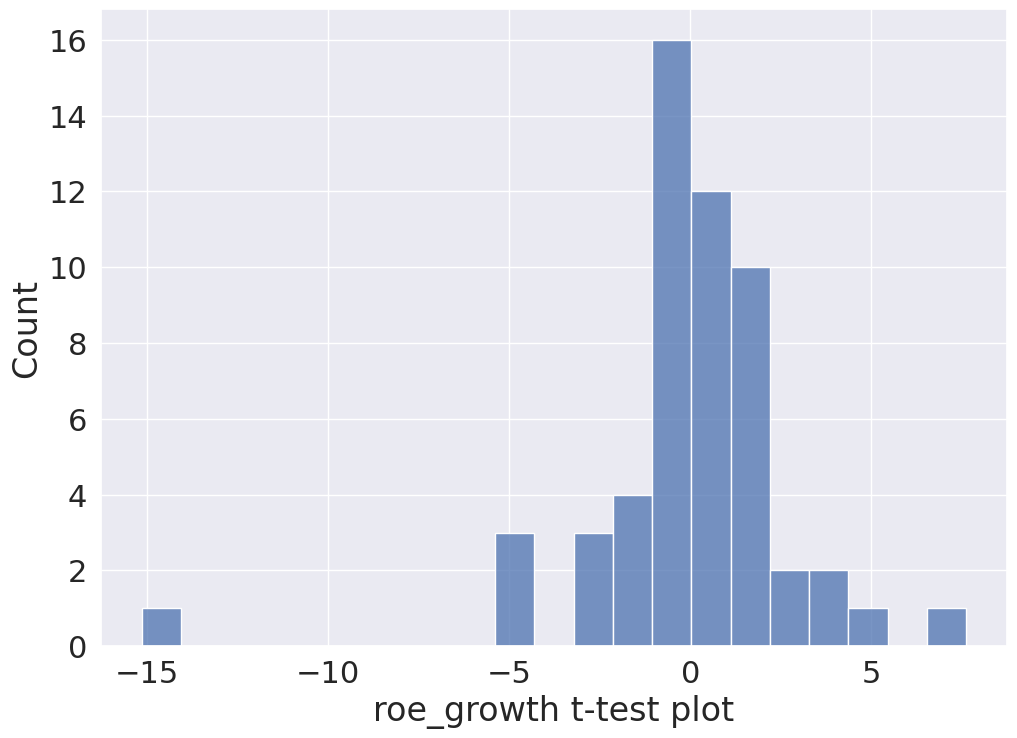

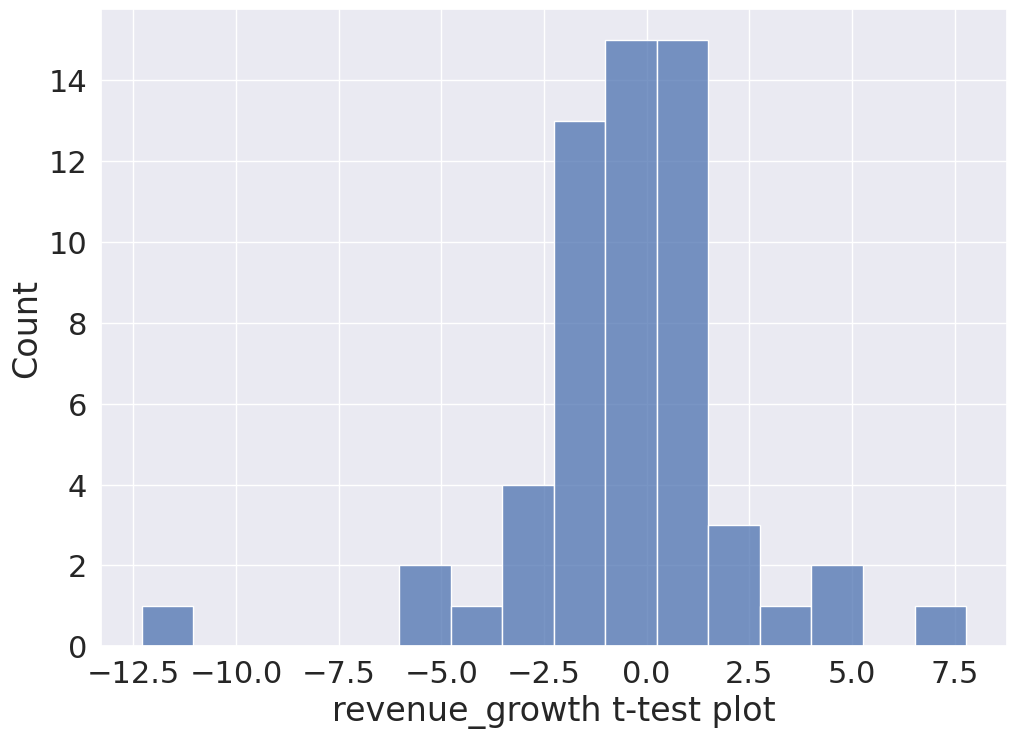

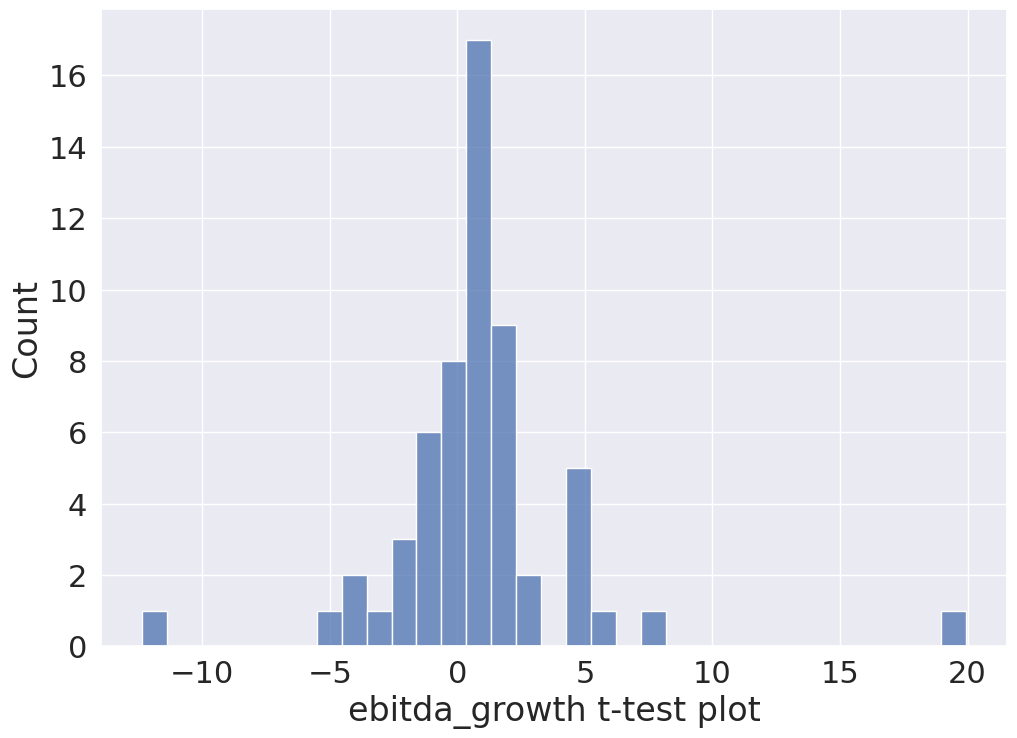

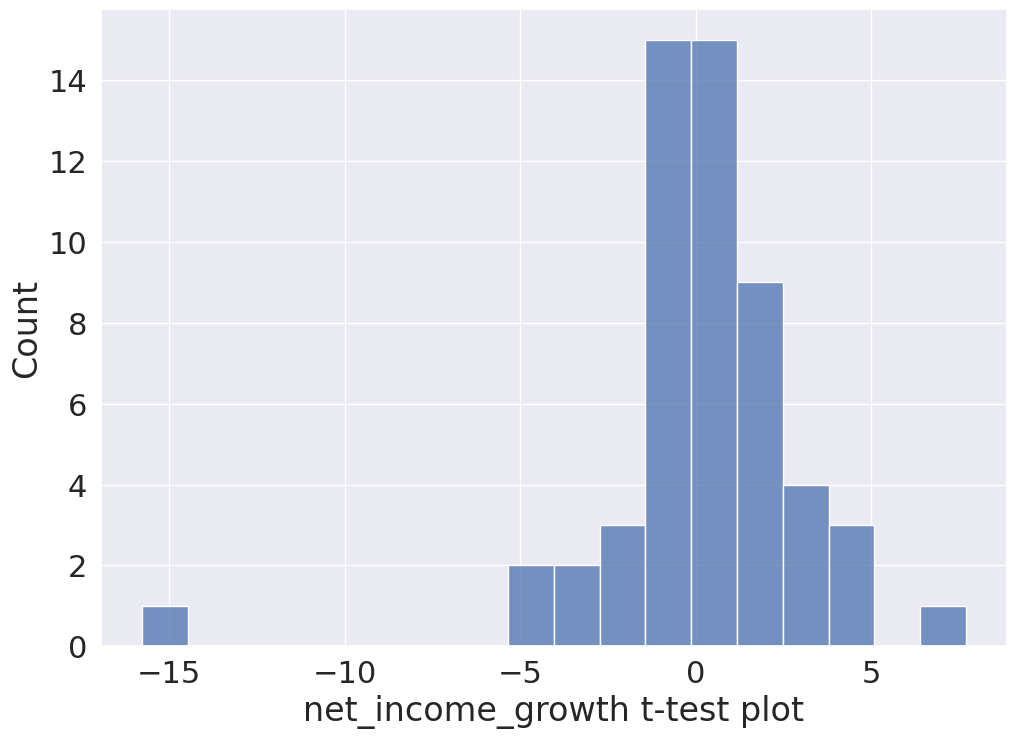

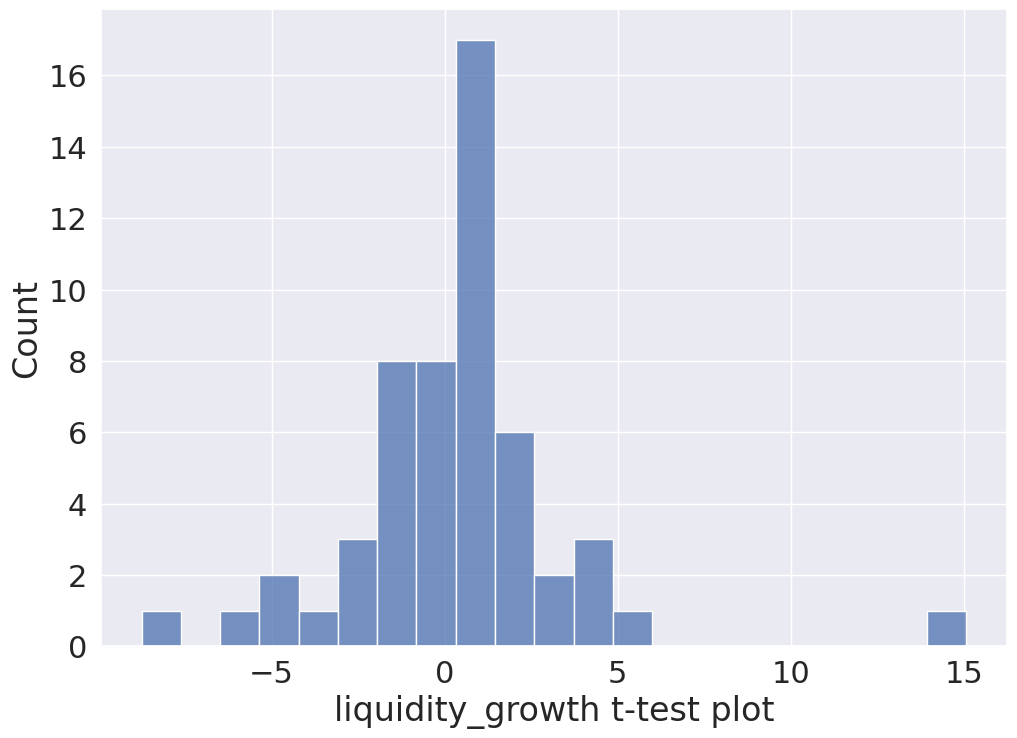

In [39]:
# When we have the proper lists, we can then plot histograms for each element
def plot_histograms(mapped_significance):
    for k, v in mapped_significance.items():
        hist = sns.histplot(x=v)
        hist.set(xlabel=(k + " t-test plot"))
        plt.show()

plot_histograms(significance_map)

### **Rerunning the T-Test on Compiled Company Significances**

Lastly, t-statistics for each of the companies is compiled into another t-test so that we may generalize the results of the analysis for portfolio companies as a whole.

In [40]:
def display_compiled_ttest(key_map):
    for k, v in key_map.items():
        X = v
        Y = 0
        print(f"{k} two-sided ttest")
        display(pg.ttest(X, Y))

display_compiled_ttest(significance_map)    

roe_growth two-sided ttest


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.340528,54,two-sided,0.73478,"[-0.95, 0.67]",0.045917,0.156,0.062915


revenue_growth two-sided ttest


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.293271,57,two-sided,0.201134,"[-1.18, 0.25]",0.169815,0.316,0.246207


ebitda_growth two-sided ttest


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.735049,57,two-sided,0.088137,"[-0.14, 1.9]",0.227823,0.585,0.399814


net_income_growth two-sided ttest


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.240009,54,two-sided,0.811232,"[-0.74, 0.94]",0.032363,0.151,0.056392


liquidity_growth two-sided ttest


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.76166,53,two-sided,0.449639,"[-0.56, 1.24]",0.103649,0.195,0.116136
